# Wheel alignment
This notebook will test code to align the wheel data from the encoder with the sound (and motor, lick, camera) data from the DAQ.

## Initial setup

### Imports

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import sys
sys.path.insert(0, '../python/')
from session import FreeSession

### Settings

In [4]:
# Directories
labview_filepath = '/media/james/mcginley_server_3/James/data/Ephys/02-04-19/labview/j6z4_d25_2019_02_04_16_29_34.mat'
sess_filepath = None

# Parameters
dt_smooth = 1.0 # length of moving average window
fs_wheel = 1.0 / 0.005 # hard-coded 5 ms sampling
v_run = 5.0 # threshold from stop to run (cm/s)
v_stop = 0.5 # threshold from run to stop (cm/s)

### Load session

In [139]:
import importlib
import session
importlib.reload(session)
from session import FreeSession

In [140]:
sess = FreeSession(labview_filepath)
if sess_filepath is not None:
    sess.load(sess_filepath)

### Load wheel data

In [76]:
sess.load_data('wheel_speed')
sess.load_data('wheel_time')
#sess.load_data('wheel_position')
v_wheel = sess.data['wheel_speed']
t_wheel = sess.data['wheel_time']
#x_wheel = sess.data['wheel_position']
x_wheel = np.cumsum(1.0 / fs_wheel * v_wheel)

## Compare wheel-based vs. sound-based patch times
The wheel times are based on the encoder (Windows) clock, whereas the sound times are based on the independently running DAQ clock. Note that although the wheel encoder is supposed to sample every 5 ms, in reality there is some variability due to other simultaneous processes. However, the LabVIEW code smooths over the last $x$ samples assuming they were sampled uniformly at 5 ms, rather than using the timestamps to determine what falls into the last $y$ second(s) of the smoothing window.

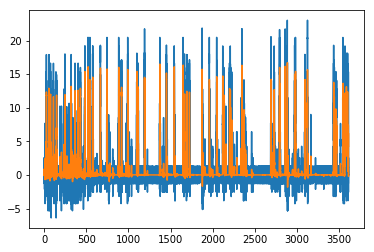

In [77]:
# Create smoothed velocity trace
num_smooth = dt_smooth * fs_wheel # number of previous samples to include for smoothing
v_smooth = np.zeros(v_wheel.shape)
for i in range(v_wheel.shape[0]):
    i_last = int(max(0, i - num_smooth + 1))
    v_smooth[i] = np.mean(v_wheel[i_last:i+1])

# Plot for comparison
plt.plot(t_wheel, v_wheel)
plt.plot(t_wheel, v_smooth)

In [126]:
# Initialize values
in_patch = True # task starts in a patch
x_start = 0.0 # linear position of current patch start
t_patch_wheel = [0.0] # patch entry/exit timestamps according to wheel data
idx_patch_wheel = [0] # indices of above timestamps

# Iterate through wheel data
for i in range(v_smooth.shape[0]):
    # Leave patch criteria:
    # 1) in a patch
    # 2) smoothed velocity exceeds threshold
    if in_patch and v_smooth[i] > v_run:
        in_patch = False
        x_start = x_wheel[i]
        t_patch_wheel.append(t_wheel[i])
        idx_patch_wheel.append(i)
    # Enter patch criteria:
    # 1) not in a patch
    # 2) smoothed velocity falls below threshold
    # 3) have covered minimum interpatch distance
    elif (not in_patch 
          and v_smooth[i] < v_stop
          and x_wheel[i] - x_start > sess.d_interpatch):
        in_patch = True
        t_patch_wheel.append(t_wheel[i])
        idx_patch_wheel.append(i)

# Get patch entry/exit timestamps from sound
t_patch_sound = sess.get_patch_times()

# Drop last patch-interpatch entry if needed
t_patch_wheel = np.array(t_patch_wheel)
t_patch_wheel = t_patch_wheel[:t_patch_sound.size].reshape([-1, 2])
idx_patch_wheel = np.array(idx_patch_wheel)
idx_stop = idx_patch_wheel[t_patch_sound.size]
idx_patch_wheel = idx_patch_wheel[:t_patch_sound.size].reshape([-1, 2])

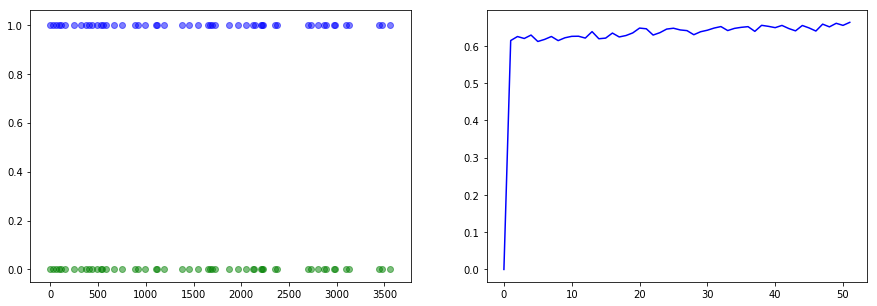

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot patch entry/exit timestamps for sound vs. wheel
ax[0].scatter(np.ones(t_patch_sound.shape[0])*t_patch_sound[:, 0], 
              np.ones(t_patch_sound.shape[0]),
              color='blue',
              alpha=0.5,
              marker='o')
ax[0].scatter(np.ones(t_patch_wheel.shape[0])*t_patch_wheel[:, 0], 
              np.zeros(t_patch_wheel.shape[0]),
              color='green',
              alpha=0.5,
              marker='o')

# Plot time difference between timestamps
ax[1].plot(t_patch_sound[:, 0] - t_patch_wheel[:, 0], color='blue')

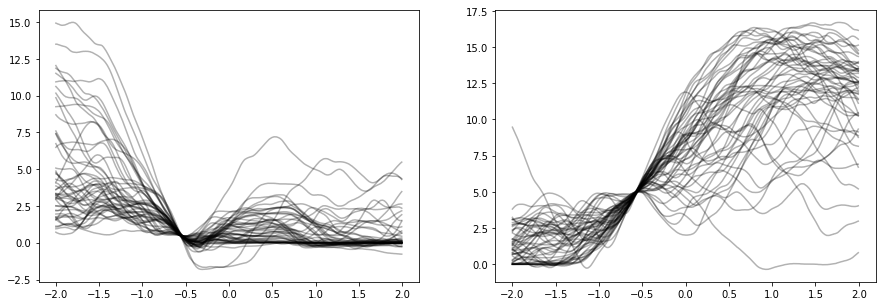

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
window = [-2.0, 2.0] # window around patch leaving (s)

# Plot wheel traces around patch entry/exit timestamps
# according to *sound*
idx = np.arange(round(window[0]*fs_wheel), round(window[1]*fs_wheel))
for i in range(t_patch_sound.shape[0]):
    # Plot trace around entering
    if i > 0: # skip t = 0.0
        idx_center = np.argwhere(np.isclose(t_wheel, t_patch_sound[i, 0], atol=1.0/fs_wheel))[0, 0]
        idx_i = idx + idx_center
        ax[0].plot(idx/fs_wheel, v_smooth[idx_i], color='black', alpha=0.3)
    
    # Plot trace around leaving
    idx_center = np.argwhere(np.isclose(t_wheel, t_patch_sound[i, 1], atol=1.0/fs_wheel))[0, 0]
    idx_i = idx + idx_center
    ax[1].plot(idx/fs_wheel, v_smooth[idx_i], color='black', alpha=0.3)

## Align wheel-based and sound-based patch times
Taking the above two figures together, it appears that there is an initial offset between the wheel and DAQ times, but actually not too much drift afterwards across the session. Next, we will align all wheel timestamps by finding the indices corresponding to sound timestamps during patch entry/exit, and interpolating in between them.

In [81]:
# Load last analyzable timestamp for interpolation function
sess.load_vars('t_stop')
t_stop = sess.vars['t_stop']

# Estimate offset between encoder and DAQ start based on
# first patch exit (first analyzable timestamp)
offset = t_patch_sound[0, 1] - t_patch_wheel[0, 1]

# Interpolate between patch entry/exit timestamps to create
# aligned wheel timestamps. Anchor wheel indices associated
# with patch entry/exit (based on smoothed velocity) to 
# corresponding timestamps based on sound. Handle special case
# of session start (first patch "entry") due to initial offset
# between DAQ and encoder.
x_interp = np.append(idx_patch_wheel.flatten(), idx_stop)
y_interp = np.append(np.insert(t_patch_sound.flatten()[1:], 0, offset), t_stop)
f = interp1d(x_interp, y_interp)
t_wheel_ = np.zeros(t_wheel.shape)
t_wheel_[:idx_stop+1] = f(np.arange(idx_stop+1))

# Assign times after last patch entry (t_stop) based
# on original wheel timestamps
t_wheel_[idx_stop+1:] = t_wheel_[idx_stop] + (t_wheel[idx_stop+1:] - t_wheel_[idx_stop])

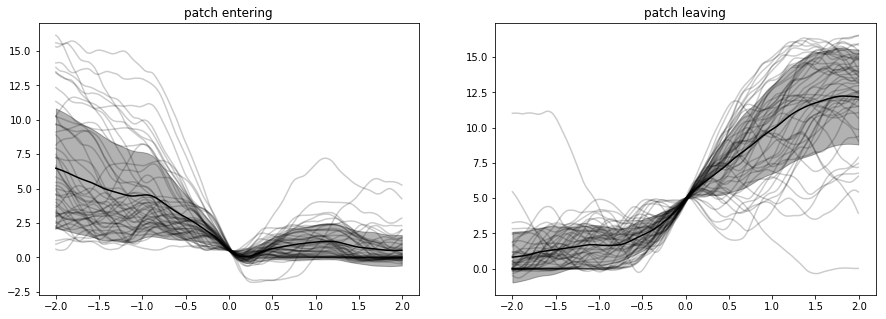

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
window = [-2.0, 2.0] # window around patch leaving (s)

# Plot *aligned* wheel traces around patch entry/exit timestamps
# according to *sound*
idx = np.arange(round(window[0]*fs_wheel), round(window[1]*fs_wheel))
v_smooth_enter = np.zeros([t_patch_sound.shape[0],idx.size])
v_smooth_leave = np.zeros([t_patch_sound.shape[0], idx.size])
for i in range(t_patch_sound.shape[0]):
    # Plot trace around entering
    if i > 0: # ignore session start
        idx_center = np.argwhere(np.isclose(t_wheel_, t_patch_sound[i, 0], atol=1.0/fs_wheel))[0, 0]
        idx_i = idx + idx_center
        ax[0].plot(idx/fs_wheel, v_smooth[idx_i], color='black', alpha=0.2)
        v_smooth_enter[i] = v_smooth[idx_i]

    # Plot trace around leaving
    idx_center = np.argwhere(np.isclose(t_wheel_, t_patch_sound[i, 1], atol=1.0/fs_wheel))[0, 0]
    idx_i = idx + idx_center
    ax[1].plot(idx/fs_wheel, v_smooth[idx_i], color='black', alpha=0.2)
    v_smooth_leave[i] = v_smooth[idx_i]

# Plot smoothed wheel trace around entering
mean = np.mean(v_smooth_enter, axis=0)
std = np.std(v_smooth_enter, axis=0)
ax[0].plot(idx/fs_wheel, mean, color='black')
ax[0].fill_between(idx/fs_wheel, y1=mean-std, y2=mean+std, color='black', alpha=0.3)
ax[0].set_title('patch entering')

# Plot smoothed wheel trace around leaving
mean = np.mean(v_smooth_leave, axis=0)
std = np.std(v_smooth_leave, axis=0)
ax[1].plot(idx/fs_wheel, mean, color='black')
ax[1].fill_between(idx/fs_wheel, y1=mean-std, y2=mean+std, color='black', alpha=0.3)
ax[1].set_title('patch leaving');

Much better! All traces converge to the stop and run thresholds for patch entry and leaving, respectively. Moreover, they are now aligned exactly at the same time as the sound indicates.

## Test `Session()` function

In [144]:
t_wheel_test = sess.get_wheel_times()
print(np.isclose(t_wheel_test, t_wheel_).all())

True


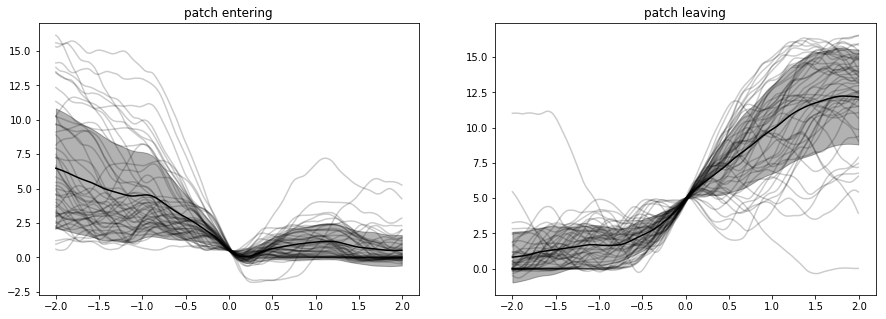

In [143]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
window = [-2.0, 2.0] # window around patch leaving (s)

# Plot *aligned* wheel traces around patch entry/exit timestamps
# according to *sound*
idx = np.arange(round(window[0]*fs_wheel), round(window[1]*fs_wheel))
v_smooth_enter = np.zeros([t_patch_sound.shape[0],idx.size])
v_smooth_leave = np.zeros([t_patch_sound.shape[0], idx.size])
for i in range(t_patch_sound.shape[0]):
    # Plot trace around entering
    if i > 0: # ignore session start
        idx_center = np.argwhere(np.isclose(t_wheel_test, t_patch_sound[i, 0], atol=1.0/fs_wheel))[0, 0]
        idx_i = idx + idx_center
        ax[0].plot(idx/fs_wheel, v_smooth[idx_i], color='black', alpha=0.2)
        v_smooth_enter[i] = v_smooth[idx_i]

    # Plot trace around leaving
    idx_center = np.argwhere(np.isclose(t_wheel_test, t_patch_sound[i, 1], atol=1.0/fs_wheel))[0, 0]
    idx_i = idx + idx_center
    ax[1].plot(idx/fs_wheel, v_smooth[idx_i], color='black', alpha=0.2)
    v_smooth_leave[i] = v_smooth[idx_i]

# Plot smoothed wheel trace around entering
mean = np.mean(v_smooth_enter, axis=0)
std = np.std(v_smooth_enter, axis=0)
ax[0].plot(idx/fs_wheel, mean, color='black')
ax[0].fill_between(idx/fs_wheel, y1=mean-std, y2=mean+std, color='black', alpha=0.3)
ax[0].set_title('patch entering')

# Plot smoothed wheel trace around leaving
mean = np.mean(v_smooth_leave, axis=0)
std = np.std(v_smooth_leave, axis=0)
ax[1].plot(idx/fs_wheel, mean, color='black')
ax[1].fill_between(idx/fs_wheel, y1=mean-std, y2=mean+std, color='black', alpha=0.3)
ax[1].set_title('patch leaving');

## Find times associated with non-patch-leaving movement

In [147]:
# Settings
v_run = sess.settings['run_config']['v_leave']
v_stop = 0.5

# Initialize values
in_patch = True # task starts in a patch
stopped_in_interpatch = False
x_start = 0.0 # linear position of current patch start
t_move = [] # timestamp associated with initiation of movement in interpatch

# Iterate through wheel data
for i in range(v_smooth.shape[0]):
    # Leave patch criteria:
    # 1) in a patch
    # 2) smoothed velocity exceeds threshold
    if in_patch and v_smooth[i] > v_run:
        in_patch = False
        x_start = x_wheel[i]

    elif (stopped_in_interpatch
          and v_smooth[i] > v_run):
        stopped_in_interpatch = False
        t_move.append(t_wheel_[i])
        
    # Enter patch criteria:
    # 1) not in a patch
    # 2) smoothed velocity falls below threshold
    # 3) have covered minimum interpatch distance
    elif (not in_patch 
          and v_smooth[i] < v_stop):
        if x_wheel[i] - x_start > sess.d_interpatch:
            in_patch = True
        else:
            stopped_in_interpatch = True

t_move = np.array(t_move)
print(t_move)

[2225.35439493]


In [151]:
from analysis import get_interpatch_move_times

In [152]:
get_interpatch_move_times(sess)

array([2225.35439493])